In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
df = pd.read_csv("promoters.data", names=["class", "id", "sequence"])

In [57]:
df.shape

(106, 3)

In [58]:
df.isnull().sum()

class       0
id          0
sequence    0
dtype: int64

In [59]:
df["class"].value_counts()

+    53
-    53
Name: class, dtype: int64

# Preprocess

In [60]:
def clear_tab(text):
    text = text.replace("\t", "")
    return text

In [61]:
df["sequence"] = df["sequence"].apply(clear_tab)

In [62]:
nucleotit_dict = {}
sequences = df["sequence"].tolist()

for i, sequence in enumerate(sequences):
    nucleotit = list(sequence)
    nucleotit.append(df.loc[i, "class"])
    nucleotit_dict[i] = nucleotit

In [ ]:
df = pd.DataFrame(nucleotit_dict)

In [ ]:
df = df.transpose()

In [ ]:
df = df.rename(columns={57: "class"})

In [71]:
le = LabelEncoder().fit(df["class"])
le_nm = dict(zip(le.classes_, le.transform(le.classes_)))
df["class"] = df["class"].apply(lambda x: le_nm[x])

In [72]:
ndf = pd.get_dummies(df)

,class,0_a,0_c,0_g,0_t,1_a,1_c,1_g,1_t,2_a,...,54_g,54_t,55_a,55_c,55_g,55_t,56_a,56_c,56_g,56_t
0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,1,1,...,1,0,0,1,0,0,0,0,1,0
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,1,0,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0


# Model Training

In [74]:
X = ndf.drop(["class"], axis=1).values
y = ndf["class"].values

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4242)

In [ ]:
mlpc_model = MLPClassifier()
mlpc_model.fit(X_train, y_train)

In [83]:
y_pred = mlpc_model.predict(X_test)
mlpc_model.score(X_test, y_test)

0.8636363636363636

In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.80      0.89      0.84         9

    accuracy                           0.86        22
   macro avg       0.86      0.87      0.86        22
weighted avg       0.87      0.86      0.86        22



# Model Tuning

In [94]:
mlpc_params = {
    'hidden_layer_sizes': [(250, 150, 50),(150,100,50),(100, 50, 25)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'max_iter': [300],
}

In [95]:
mlpc = MLPClassifier()
mlpc_cv_model = GridSearchCV(mlpc, mlpc_params, cv=10, n_jobs=-1)
mlpc_cv_model.fit(X_train, y_train)
mlpc_cv_model.best_params_

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

{'activation': 'relu',
 'hidden_layer_sizes': (100, 50, 25),
 'max_iter': 300,
 'solver': 'adam'}

In [ ]:
mlpc_tuned = MLPClassifier(activation="relu", hidden_layer_sizes=(75, 50, 25), max_iter=300, solver="adam")
mlpc_tuned.fit(X_train, y_train)

In [101]:
y_pred = mlpc_tuned.predict(X_test)
mlpc_tuned.score(X_test, y_test)

0.9090909090909091

In [102]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.89      0.89      0.89         9

    accuracy                           0.91        22
   macro avg       0.91      0.91      0.91        22
weighted avg       0.91      0.91      0.91        22



<AxesSubplot: >

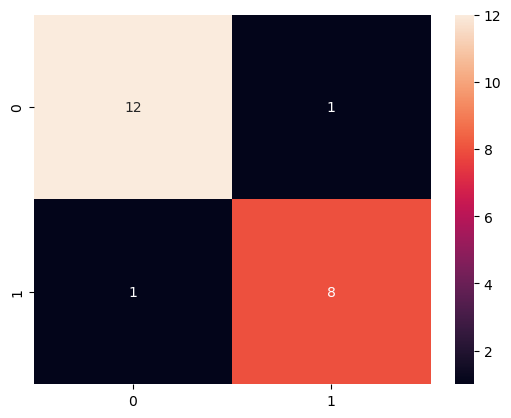

In [103]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

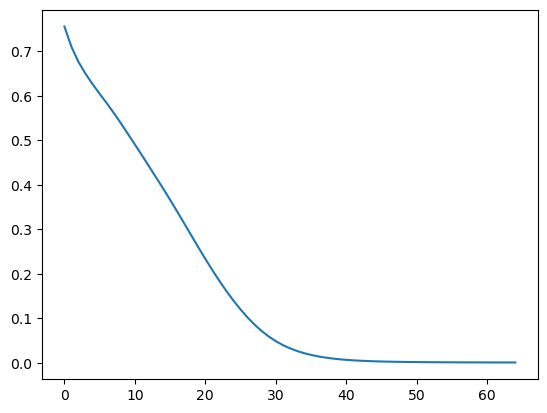

In [104]:
plt.plot(mlpc_tuned.loss_curve_)
plt.show()

# Saving Model

In [112]:
enc_df = df.drop(["class"], axis=1)
encoder = OneHotEncoder().fit(enc_df)

In [113]:
pickle.dump(encoder, open("EColiEncoder.pickle", "wb"))

In [105]:
pickle.dump(mlpc_tuned, open("EColiModel.pickle", "wb"))

In [ ]:
model = pickle.load(open("EColiModel.pickle", "rb"))
encode = pickle.load(open("EColiEncoder.pickle", "rb"))